In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_scan_util import GridScan
pd.set_option('display.max_columns', None)

In [2]:
scan = GridScan.load("main_v2", root="results")

df_filename = "analysis.parquet"

# Comment this out if you don't need to reload and export the trials
# scan.export_trials_df(df_filename, loading_progress=True)

trials_df = scan.load_exported_trials_df(df_filename)
trials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Columns: 124 entries, run_id to metrics.train_time_std
dtypes: float64(91), int64(27), object(6)
memory usage: 352.8+ KB


In [3]:
trials_df.head()

,run_id,config_hash,started_at,finished_at,duration,error,config.device_count,config.seed,config.tau,config.I0,config.eps,config.Nout,config.w_scale,config.T,config.K,config.dt,config.gamma,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nin,config.Nsamples,config.Nin_virtual,config.Nhidden,config.Nlayer,config.Nbatch,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.epoch_time_mean,metrics.epoch_time_std,metrics.init_compile_time_mean,metrics.init_compile_time_std,metrics.init_optim_time_mean,metrics.init_optim_time_std,metrics.init_phi0_time_mean,metrics.init_phi0_time_std,metrics.init_time_mean,metrics.init_time_std,metrics.init_weights_time_mean,metrics.init_weights_time_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std,metrics.train_time_mean,metrics.train_time_std
0,20240914_223231,01afceedb61e7fe0be95f2f084b305ba,2024-09-14_23-58-23_340065,2024-09-14_23-59-46_177046,82.836981,None,1,0,1.909859,1.25,0.000001,20,0.5,2.0,300,0.001,0.01,0.004,100.0,0.9,0.999,0.0,20,None,700,3,56,200,3,1000,0.051828,0.003018,0.042077,0.001159,20,0.042077,0.001159,2,0.135751,0.021739,0.048273,0.004225,0.042077,0.001159,20,0.042077,0.001159,12,0.049202,0.004615,0.174034,0.003098,0.000000,0.000000,3,0.000000,0.000000,2,0.303414,0.025220,0.174034,0.003098,0.000000,0.000000,3,0.000000,0.000000,2,0.299763,0.021224,1.189569,0.042568,0.000592,0.000006,0.002325,0.000051,0.000623,0.000108,2.326245,0.309252,0.001243,0.000060,3.043758,0.009795,NaN,NaN,1,3.010447,0.003326,0,3.043758,0.009795,3.012916,0.0,3.012916,0.000000,2,3.011967,0.001342,0,3.012916,0.0,0.570833,0.013123,1.000000,0.000000,2,0.544167,0.044457,3,1.000000,0.000000,0.570833,0.013123,1.000000,0.000000,2,0.545833,0.042834,3,1.000000,0.000000,23.791372,0.851351
1,20240915_152716,01b0ba501f062251af11832e7526d531,2024-09

## Error Summary

In [4]:
n_error = trials_df["error"].notna().sum()
print(f"{n_error} / {len(trials_df)} trials contain errors")
print()

for i, error in enumerate(trials_df["error"].dropna().sort_values().unique()):
    short_error = str(error).split("---", 1)[0].strip().split("\n")[-1]
    print(short_error)
    trials = trials_df[trials_df["error"] == error]
    print(f"Appears in {len(trials)} trials: {trials['config_hash'].tolist()}")
    print()

0 / 364 trials contain errors



In [5]:
# def load_trials_df(version: int):
#     filename = f"grid_data_{version:02d}.yaml"

#     with open(filename, "r") as f:
#         data = yaml.safe_load(f)

#     trials = []

#     for trial in data["trials"].values():
#         for k, v in trial["config"].items():
#             trial[f"config.{k}"] = v
#         del trial["config"]

#         for k, v in trial["metrics"].items():
#             trial[f"metrics.{k}"] = v
#         del trial["metrics"]

#         trials.append(trial)

#     return pd.DataFrame(trials)

# trials_df = load_trials_df(version=1)
# trials_df.info()

In [6]:
from typing import Hashable

def safe_nunique(series):
    try:
        return series.nunique()
    except TypeError:
        return -1

def plot_config_dependency(df, agg_funcs=("max",), agg_kwargs=dict(numeric_only=True)):
    config_cols = [
        col
        for col in df.columns
        if col.startswith("config.") and safe_nunique(df[col]) > 1
    ]

    fig, axs = plt.subplots(2, len(config_cols), figsize=(3 * len(config_cols), 5), sharey="row", sharex="col", squeeze=False)

    for (agg_ax, count_ax), config_col in zip(axs.T, config_cols):
        grouped = df.groupby(config_col)

        for agg_func in agg_funcs:
            agg_df = grouped.aggregate(agg_func, **agg_kwargs)
            
            agg_df.plot(
                ax=agg_ax,
                y="metrics.acc_max_mean",
                marker=".",
                linestyle="--",
                label=agg_func,
            )

        grouped.count().plot(
            ax=count_ax,
            y="metrics.acc_max_mean",
            marker=".",
            linestyle="--",
            label="success",
            color="green",
        )
        grouped.count().plot(
            ax=count_ax,
            y="error",
            marker=".",
            linestyle="--",
            label="error",
            color="red",
        )
        grouped.size().plot(
            ax=count_ax,
            marker=".",
            linestyle="--",
            label="total",
            color="black",
        )

        agg_ax.set_ylabel("Accuracy")
        agg_ax.grid()
        agg_ax.legend()

        count_ax.set_xlabel(config_col.removeprefix("config."))
        count_ax.set_ylabel("Trial count")
        count_ax.grid()
        count_ax.legend()

    plt.tight_layout()
    plt.show()

# plot_config_dependency(trials_df)

The problem with these graphs is that we cannot really determine which config parameters lead to which accuracy change.
For this, we have to fix all config parameters, except one and plot the accuracy against the single free parameter.

## Dependencies on `Nt`

In [7]:
from spikegd.utils.plotting import LinePlot, PlotGrid


def key_format(key: str):
    return key.removeprefix("config.").removeprefix("metrics.")


indep_keys = tuple(
    key for key in trials_df.columns
    if key.startswith("config.") and key != "config.Nin"
)
print("independent keys:", indep_keys)

# PlotGrid(
#     arg_keys=("config.Nt",),
#     func_keys=(
#         "metrics.acc_max_mean",
#         "metrics.epoch_time_mean"
#     ),
#     plot_type=LinePlot(
#         graph_key="config.Nbatch",
#         x_scale="log",
#     ),
#     col_key="config.Nin_virtual",
#     whitelists={"config.Nin_virtual": [8, 16, 24]},
#     indep_keys=indep_keys,
#     key_format=key_format,
# ).show(trials_df)

independent keys: ('config.device_count', 'config.seed', 'config.tau', 'config.I0', 'config.eps', 'config.Nout', 'config.w_scale', 'config.T', 'config.K', 'config.dt', 'config.gamma', 'config.lr', 'config.tau_lr', 'config.beta1', 'config.beta2', 'config.p_flip', 'config.Nepochs', 'config.Ntrain', 'config.Nsamples', 'config.Nin_virtual', 'config.Nhidden', 'config.Nlayer', 'config.Nbatch')


## Dependencies on `Nin_virtual`

Independent key 'config.tau' has multiple values: [1.909859317102744, 0.954929658551372]. Using most frequent value: 1.909859317102744
Independent key 'config.I0' has multiple values: [1.25, 1.125, 1.375]. Using most frequent value: 1.25
Independent key 'config.gamma' has multiple values: [0.01, 0.001]. Using most frequent value: 0.01
Independent key 'config.lr' has multiple values: [0.004, 0.001]. Using most frequent value: 0.004
Independent key 'config.Nhidden' has multiple values: [200, 100, 300]. Using most frequent value: 200
Independent key 'config.Nlayer' has multiple values: [3, 2]. Using most frequent value: 3


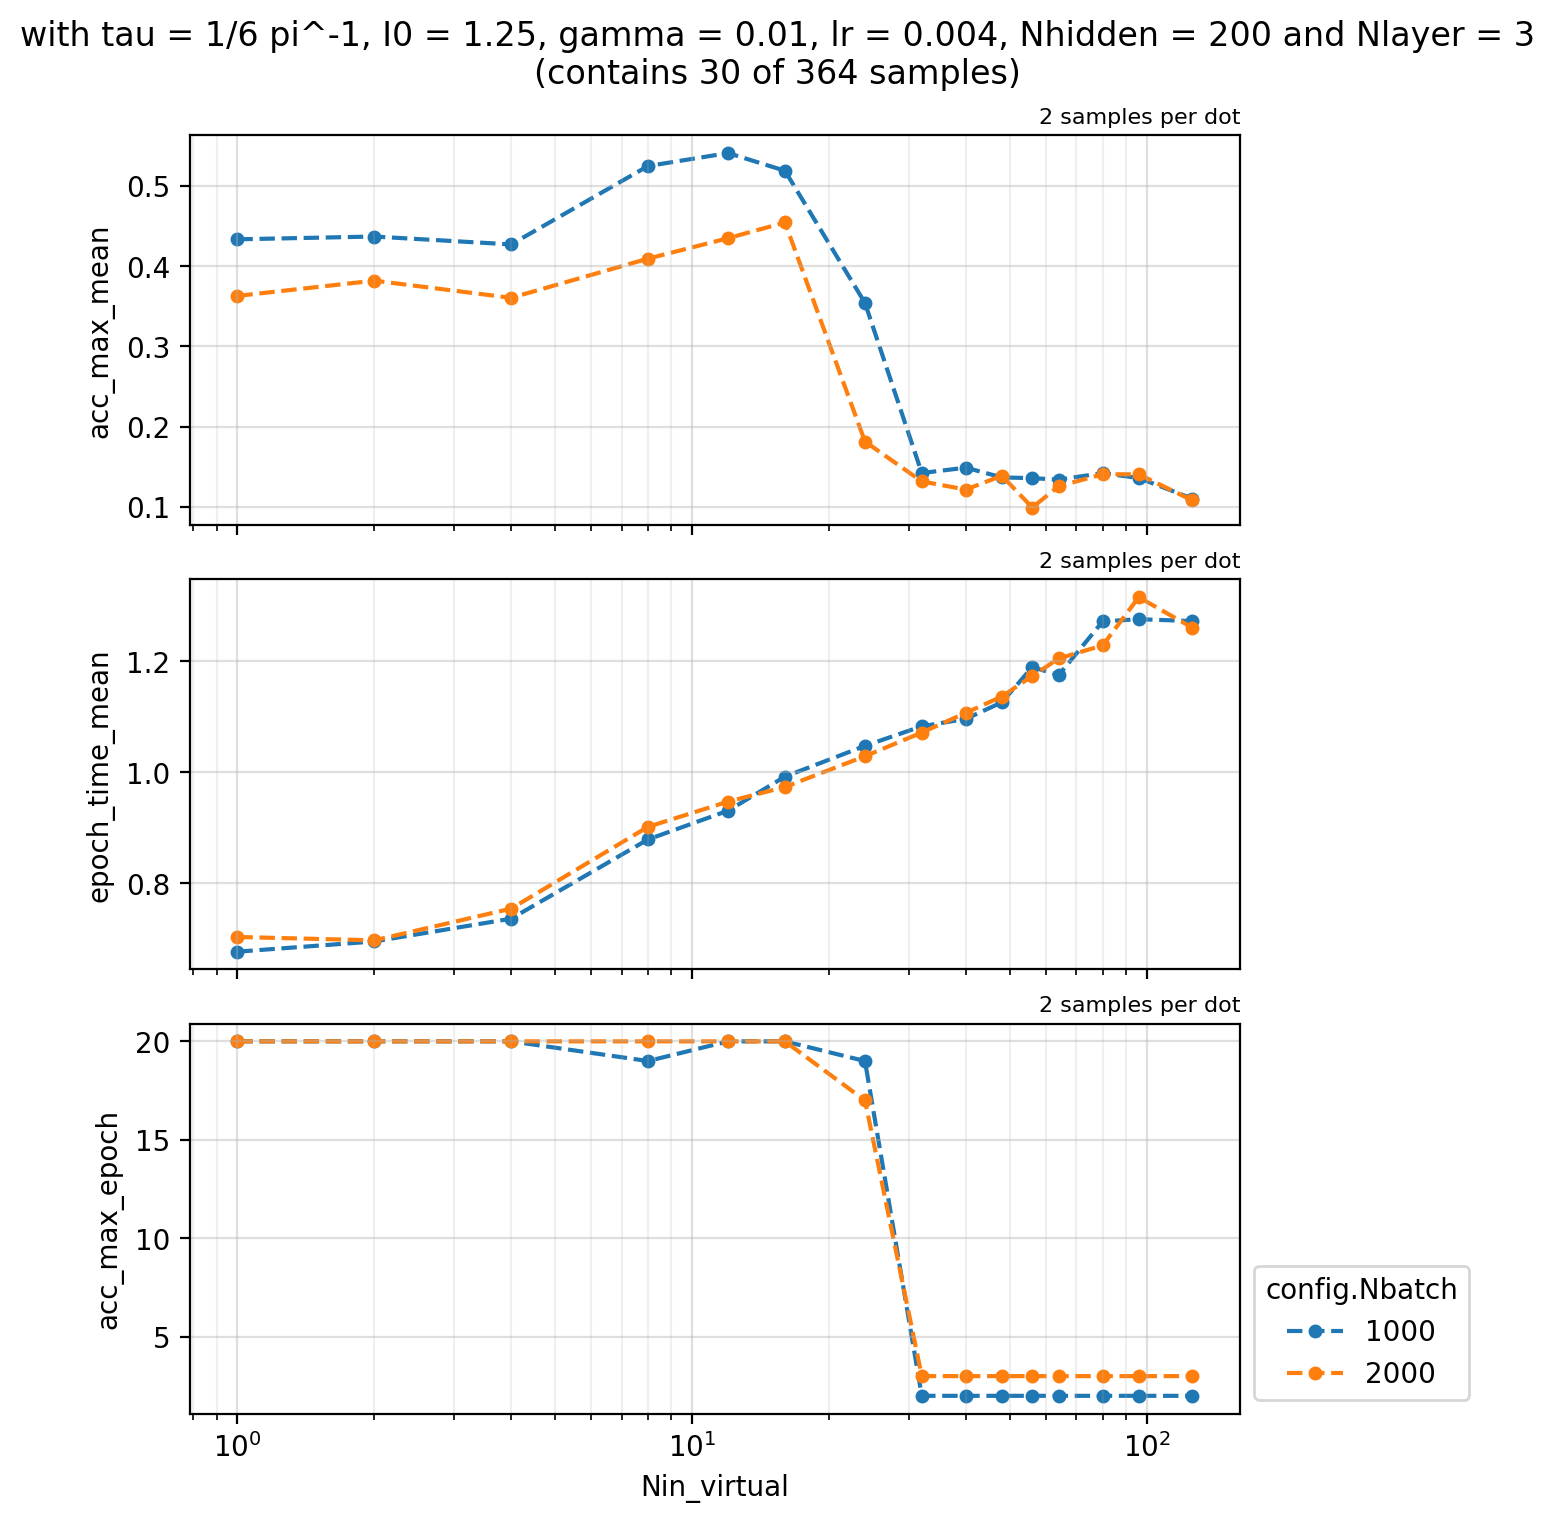

In [8]:
PlotGrid(
    arg_keys=("config.Nin_virtual",),
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.epoch_time_mean",
        "metrics.acc_max_epoch"
    ),
    plot_type=LinePlot(
        graph_key="config.Nbatch",
        x_scale="log",
    ),
    # whitelists={"config.Nt": [8, 12, 16]},    
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

Independent key 'config.tau' has multiple values: [1.909859317102744, 0.954929658551372]. Using most frequent value: 1.909859317102744
Independent key 'config.I0' has multiple values: [1.25, 1.125, 1.375]. Using most frequent value: 1.25
Independent key 'config.gamma' has multiple values: [0.01, 0.001]. Using most frequent value: 0.01
Independent key 'config.lr' has multiple values: [0.004, 0.001]. Using most frequent value: 0.004
Independent key 'config.Nbatch' has multiple values: [1000, 2000]. Using most frequent value: 1000


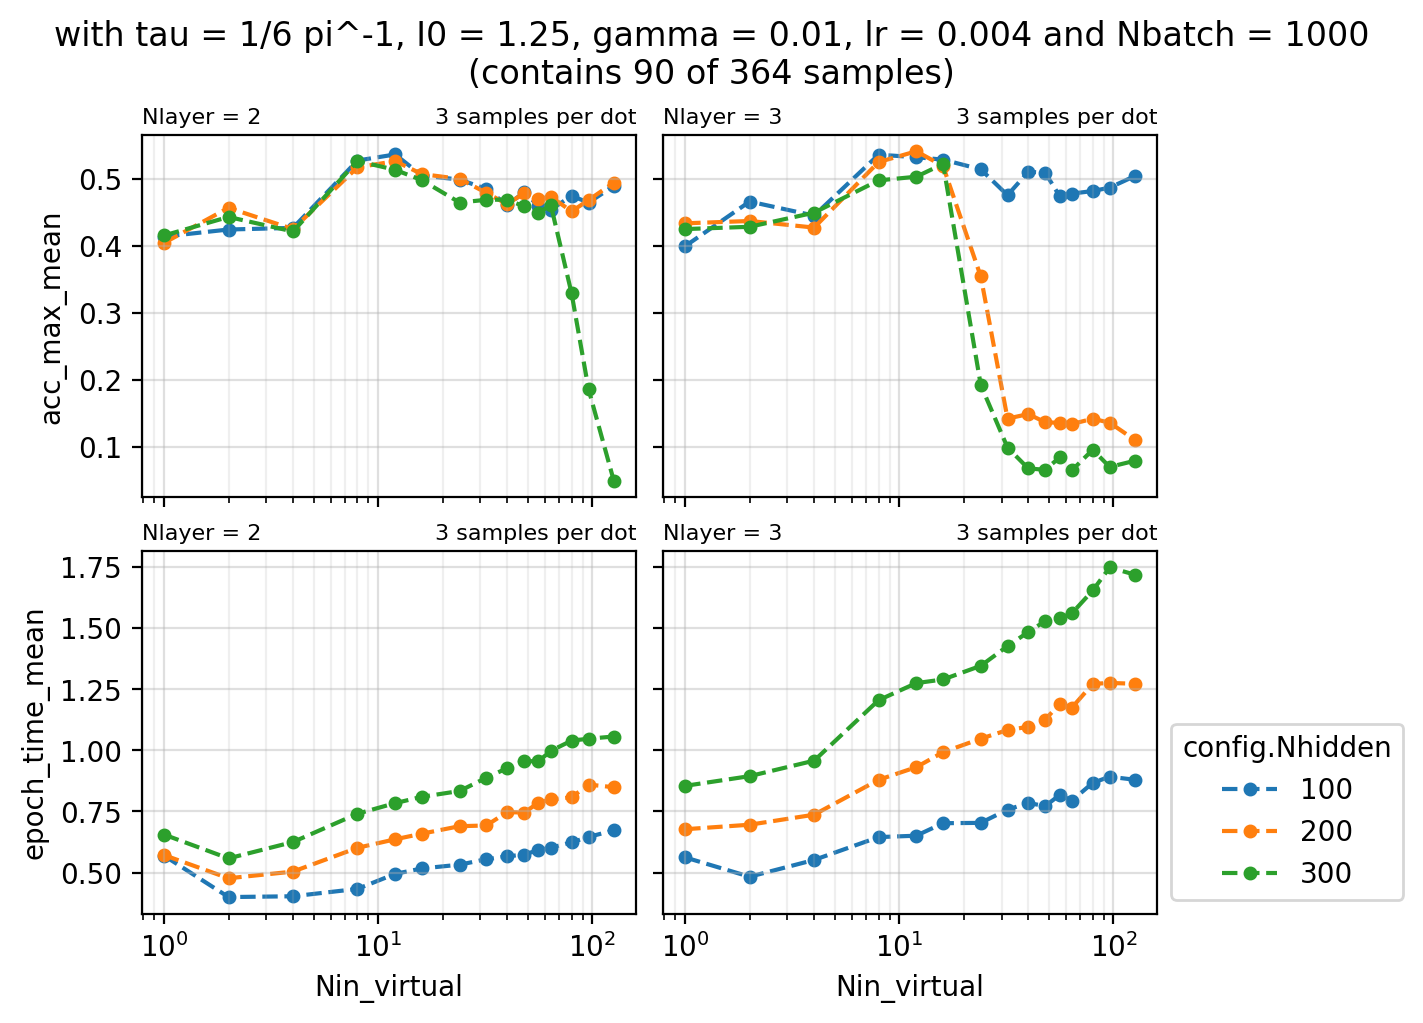

In [9]:
PlotGrid(
    arg_keys=("config.Nin_virtual",),
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.epoch_time_mean"
    ),
    plot_type=LinePlot(
        graph_key="config.Nhidden",
        x_scale="log",
    ),
    col_key="config.Nlayer",
    # whitelists={"config.Nt": [8, 12, 16]},
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

## Dependencies on `Nt` and `Nin_virtual`

In [10]:
# from spikegd.utils.plotting import HeatmapPlot
# from matplotlib.colors import LogNorm

# PlotGrid(
#     arg_keys=("config.Nt", "config.Nin_virtual"),
#     func_keys=("metrics.acc_max_mean",),
#     plot_type=HeatmapPlot(),
#     # limits={"metrics.acc_max_mean": (0.7, None)},
#     col_key="config.Nbatch",
#     indep_keys=indep_keys,
#     key_format=key_format,
#     whitelists={"config.Nbatch": [1000, 2000]},
# ).show(trials_df)

In [11]:
# plot_dataframe(
#     trials_df,
#     x_key="config.Nhidden",
#     y_keys=("metrics.acc_max_mean", "metrics.acc_max_epoch", "metrics.epoch_time_mean"),
#     # graph_key="config.Nhidden",
#     # col_key="Nin_virtual",
#     fixed_values={"config.Nlayer": 2, "config.Nbatch": 1000, "config.Nt": 10},
#     mean_keys=("config.Nin_virtual", "config.Nin"),
#     indep_keys="config.*",
#     key_format=key_format,
# )

## Dependence of accuracy on `K`

In [12]:
# plot_single_config_key_dependency(
#     trials_df,
#     y_cols=("metrics.acc_max_mean",),
#     free_key="K",
#     col_key="Nhidden",
#     row_key="Nt",
#     graph_key="Nin_virtual",
#     fixed_values={"p_flip": 0, "Nlayer": 2},
#     mean_keys=("Nin", "Nepochs"), # Nin is computed from Nin_virtual and Nt
#     min_points_per_val=10
# )

Here, we can see that the accuracy is essentially independent of `K`, assuming that `K` is sufficiently high. The case for insufficiently high `K` can be seen for high `Nhidden` on the right.

## Dependence of accuracy and duration on `N_t`

In [13]:
# plot_single_config_key_dependency(
#     trials_df,
#     y_cols=("metrics.acc_max_mean", "duration"),
#     free_key="Nt",
#     fixed_values={"p_flip": 0, "Nhidden": 200, "Nin_virtual": 16, "Nlayer": 2, "Nepochs": 20},
#     mean_keys=("Nin", "K") # Nin is computed from Nin_virtual and Nt
# )

The accuracy plateaus above around `Nt = 7`. The duration on the other hand roughly increases linearly with `Nt`. It should therefore be best to choose a fixed `Nt` (e.g. around 10).

## Best trials

In [14]:
trials_df.sort_values("metrics.acc_max_mean", ascending=False).head(10)

,run_id,config_hash,started_at,finished_at,duration,error,config.device_count,config.seed,config.tau,config.I0,config.eps,config.Nout,config.w_scale,config.T,config.K,config.dt,config.gamma,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nin,config.Nsamples,config.Nin_virtual,config.Nhidden,config.Nlayer,config.Nbatch,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.epoch_time_mean,metrics.epoch_time_std,metrics.init_compile_time_mean,metrics.init_compile_time_std,metrics.init_optim_time_mean,metrics.init_optim_time_std,metrics.init_phi0_time_mean,metrics.init_phi0_time_std,metrics.init_time_mean,metrics.init_time_std,metrics.init_weights_time_mean,metrics.init_weights_time_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std,metrics.train_time_mean,metrics.train_time_std
5,20240915_152603,03951391a4568383febe18f0d7b3745e,2024-09-15_15-30-46_865743,2024-09-15_15-31-45_563423,58.697680,None,1,0,1.909859,1.250,0.000001,20,0.5,2.0,300,0.001,0.001,0.001,10.0,0.9,0.999,0.0,40,None,700,3,1,100,2,500,0.054407,0.015536,0.569263,0.011156,0,0.054407,0.015536,39,0.569350,0.007841,0.044246,0.000876,0.133380,0.015476,0,0.044246,0.000876,37,0.142950,0.016300,0.662004,0.097892,0.601871,0.022209,7,0.552600,0.024577,0,0.662004,0.097892,0.662004,0.097892,0.601327,0.022275,7,0.552518,0.024594,0,0.662004,0.097892,0.416821,0.009842,0.000632,0.000006,0.002337,0.000250,0.000843,0.000034,1.736547,0.222139,0.001086,0.000058,3.062358,0.014712,1.503054,0.022562,17,1.460602,0.047267,0,3.062358,0.014712,2.997451,0.0,2.988632,0.003158,39,2.987914,0.003954,0,2.997451,0.0,0.166667,0.033993,0.123333,0.016997,37,0.120000,0.014142,1,0.443333,0.026247,0.166667,0.033993,0.123333,0.016997,37,0.120000,0.014142,1,0.443333,0.026247,16.672836,0.393699
248,20240915_152603,aba25308cdc87cd036d12d499c

In [15]:
best_trial = trials_df.loc[trials_df["metrics.acc_max_mean"].idxmax()]
print("===== BEST TRIAL =====")
print(best_trial[[
    "config_hash", "duration",
    *indep_keys,
    "metrics.acc_max_mean", "metrics.acc_max_std", "metrics.acc_max_epoch"
]])

===== BEST TRIAL =====
config_hash              03951391a4568383febe18f0d7b3745e
duration                                         58.69768
config.device_count                                     1
config.seed                                             0
config.tau                                       1.909859
config.I0                                            1.25
config.eps                                       0.000001
config.Nout                                            20
config.w_scale                                        0.5
config.T                                              2.0
config.K                                              300
config.dt                                           0.001
config.gamma                                        0.001
config.lr                                           0.001
config.tau_lr                                        10.0
config.beta1                                          0.9
config.beta2                                     

===== BEST TRIAL 0 =====
CONFIG
- device_count            1
- seed                    0
- tau                     1/6 pi^-1
- I0                      1.25
- eps                     1e-06
- Nout                    20
- w_scale                 0.5
- T                       2
- K                       300
- dt                      0.001
- gamma                   0.001
- lr                      0.001
- tau_lr                  10
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 40
- Ntrain                  None
- Nin                     700
- Nsamples                3
- Nin_virtual             1
- Nhidden                 100
- Nlayer                  2
- Nbatch                  500
METRICS
- acc_init                      0.0544 ± 0.0155
- acc_final                     0.5693 ± 0.0112
- acc_min                       0.0544 ± 0.0155 at epoch 0
- acc_max                       0.5694 ± 0.0078 at epoch 39
- acc_ord_init          

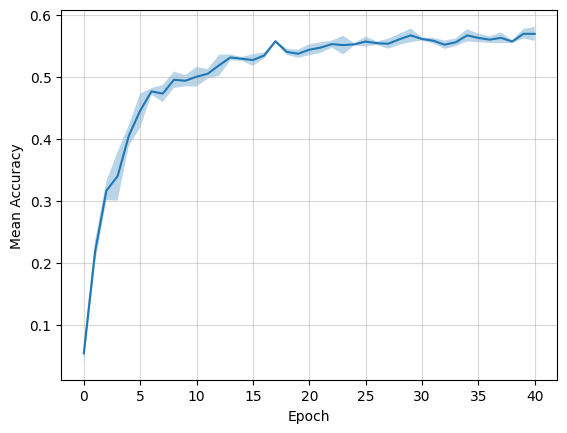

===== BEST TRIAL 1 =====
CONFIG
- device_count            1
- seed                    0
- tau                     1/6 pi^-1
- I0                      1.38
- eps                     1e-06
- Nout                    20
- w_scale                 0.5
- T                       2
- K                       300
- dt                      0.001
- gamma                   0.001
- lr                      0.001
- tau_lr                  10
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 40
- Ntrain                  None
- Nin                     700
- Nsamples                3
- Nin_virtual             1
- Nhidden                 100
- Nlayer                  2
- Nbatch                  500
METRICS
- acc_init                      0.0548 ± 0.0149
- acc_final                     0.5571 ± 0.0028
- acc_min                       0.0548 ± 0.0149 at epoch 0
- acc_max                       0.5640 ± 0.0039 at epoch 29
- acc_ord_init          

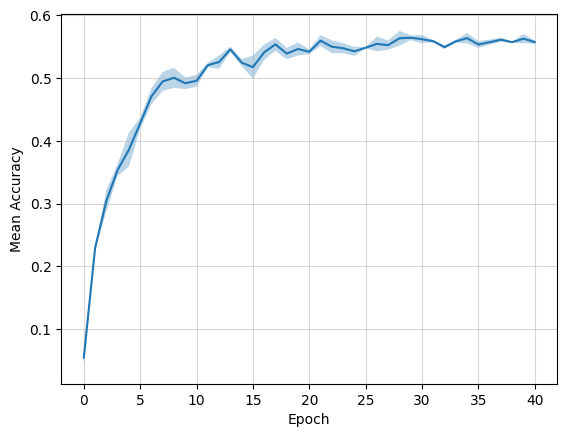

===== BEST TRIAL 2 =====
CONFIG
- device_count            1
- seed                    0
- tau                     1/6 pi^-1
- I0                      1.38
- eps                     1e-06
- Nout                    20
- w_scale                 0.5
- T                       2
- K                       300
- dt                      0.001
- gamma                   0.01
- lr                      0.001
- tau_lr                  10
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 40
- Ntrain                  None
- Nin                     700
- Nsamples                3
- Nin_virtual             1
- Nhidden                 100
- Nlayer                  2
- Nbatch                  500
METRICS
- acc_init                      0.0548 ± 0.0149
- acc_final                     0.5546 ± 0.0088
- acc_min                       0.0548 ± 0.0149 at epoch 0
- acc_max                       0.5580 ± 0.0190 at epoch 34
- acc_ord_init           

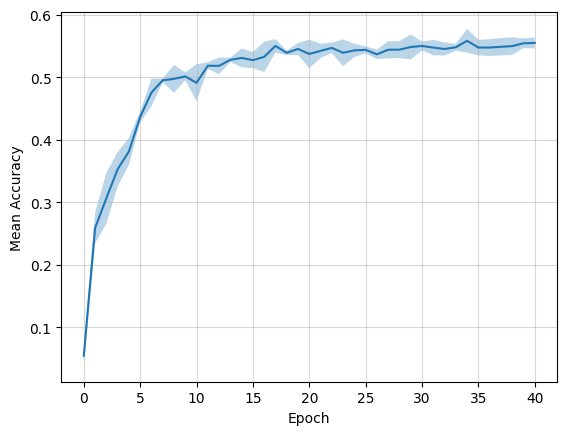

In [32]:
from spikegd.utils.formatting import print_dict

def plot_training_curves(config_hash):
    trial = scan.load_trial(config_hash)
    epoch_metrics: list = trial.metrics["epochs"]
    
    epochs = np.arange(len(epoch_metrics))
    acc_mean = np.array([metrics["acc_mean"] for metrics in epoch_metrics])
    acc_std = np.array([metrics["acc_std"] for metrics in epoch_metrics])
    
    fig, ax = plt.subplots()

    ax.plot(epochs, acc_mean)
    ax.fill_between(epochs, acc_mean - acc_std, acc_mean + acc_std, alpha=0.3)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean Accuracy")
    ax.grid(alpha=0.5)

    plt.show()

def summarize_trial(trial_row):
    print("CONFIG")
    print_dict(
        {
            "- " + key.removeprefix("config."): value
            for key, value in trial_row.items()
            if key.startswith("config.")
        }
    )
    print("METRICS")

    def summarize_metric(mean_key):
        std_key = mean_key.replace("_mean", "_std")
        epoch_key = mean_key.replace("_mean", "_epoch")

        s = f"{trial_row[mean_key]:.4f}"

        if std_key in trial_row:
            s += f" ± {trial_row[std_key]:.4f}"

        if epoch_key in trial_row:
            s += f" at epoch {trial_row[epoch_key]:.0f}"

        return s

    print_dict(
        {
            "- " + key.removeprefix("metrics.").removesuffix("_mean"): summarize_metric(key)
            for key, value in trial_row.items()
            if key.startswith("metrics.") and key.endswith("_mean")
        },
        indent=32,
    )

best_trials = trials_df \
    .sort_values("metrics.acc_max_mean", ascending=False, ignore_index=True) \
    .head(3)

for i, best_trial in best_trials.iterrows():
    print(f"===== BEST TRIAL {i} =====")
    # print(f"Max accuracy: {best_trial['metrics.acc_max_mean']:.4f} ± {best_trial['metrics.acc_max_std']:.4f} at epoch {best_trial['metrics.acc_max_epoch']}")
    summarize_trial(best_trial)
    plot_training_curves(best_trial["config_hash"])